In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py

## Input

In [4]:
chain = 'Arbitrum'

In [5]:
data_fnames = os.listdir(os.path.join(data_dir, chain)) # names of all data files

# collect the names of the files for this analysis
fnames = dict()
for fname in data_fnames:
    if fname.startswith('Fees'):
        fnames['Fees'] = fname
    if fname.startswith('Swap Sources'):
        fnames['Swap Sources'] = fname
fnames

{'Fees': 'Fees_2021-08-31_2022-09-07.csv',
 'Swap Sources': 'Swap Sources_2022-08-19_2022-09-07.csv'}

In [6]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)

## Prep Fees Data

In [7]:
# only read the first 7 cols since the last col "Cumulative" is NOT the daily total, but cumulative daily total, 
# which we don't want.
df_fees = pd.read_csv(os.path.join(data_dir, chain, fnames['Fees']), 
                      parse_dates=['Date'], index_col='Date', usecols=range(6))
df_fees.columns = df_fees.columns.str.lower().str.replace(' ', '_') + '_fees'
# calc daily total 
df_fees['total_fees'] = df_fees.sum(axis=1)

print(df_fees.info())
df_fees.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373 entries, 2021-08-31 to 2022-09-07
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   swap_fees            373 non-null    float64
 1   margin_trading_fees  373 non-null    float64
 2   mint_glp_fees        373 non-null    float64
 3   burn_glp_fees        373 non-null    float64
 4   liquidation_fees     373 non-null    float64
 5   total_fees           373 non-null    float64
dtypes: float64(6)
memory usage: 20.4 KB
None


,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees
Date,,,,,,
2021-08-31,0.3993,0.1533,0.1183,0.2062,0.0000,0.8770
2021-09-01,866.3653,101.8488,"4,843.2267",0.0337,0.0000,"5,811.4746"
2021-09-02,854.0028,741.7089,"1,610.5278",134.2650,0.0000,"3,340.5044"
2021-09-03,"1,388.2414","3,127.2669",22.3804,0.0000,0.0000,"4,537.8886"
2021-09-04,219.0247,768.7568,82.8838,0.0000,0.0000,"1,070.6653"


In [8]:
# drop the first row because nearly no activity on day 1
# drop the last row because the most recent date may not be a full day
df_fees = df_fees.iloc[1:-1, :]
df_fees.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 371 entries, 2021-09-01 to 2022-09-06
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   swap_fees            371 non-null    float64
 1   margin_trading_fees  371 non-null    float64
 2   mint_glp_fees        371 non-null    float64
 3   burn_glp_fees        371 non-null    float64
 4   liquidation_fees     371 non-null    float64
 5   total_fees           371 non-null    float64
dtypes: float64(6)
memory usage: 20.3 KB


In [9]:
# we have two years data so we use year and week numbers (1 to 52)
year_week = df_fees.index.isocalendar().drop('day', axis=1)
df_fees = pd.concat([year_week, df_fees], axis=1)
df_fees.head()

,year,week,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees
Date,,,,,,,,
2021-09-01,2021,35,866.3653,101.8488,"4,843.2267",0.0337,0.0000,"5,811.4746"
2021-09-02,2021,35,854.0028,741.7089,"1,610.5278",134.2650,0.0000,"3,340.5044"
2021-09-03,2021,35,"1,388.2414","3,127.2669",22.3804,0.0000,0.0000,"4,537.8886"
2021-09-04,2021,35,219.0247,768.7568,82.8838,0.0000,0.0000,"1,070.6653"
2021-09-05,2021,35,277.1210,784.1034,106.0886,0.0000,0.0000,"1,167.3130"


## Where did most fees come from? 

- Margin trading and liquidation fees come from traders.
- GLP minting and burning fees come from GLP liquidity providers.
- Swap fees come from swaps.

In [10]:
da = (df_fees.groupby(['year', 'week']).sum()
      .assign(trader_fees = lambda x: x.margin_trading_fees + x.liquidation_fees,
              glper_fees = lambda x: x.mint_glp_fees + x.burn_glp_fees,
              swap_fees_pct = lambda x: x.swap_fees / x.total_fees,
              trader_fees_pct = lambda x: x.trader_fees / x.total_fees,
              glper_fees_pct = lambda x: x.glper_fees / x.total_fees)
      .loc[:, ['trader_fees_pct', 'swap_fees_pct', 'glper_fees_pct']])
da.head(10)

trader_fees_pct  swap_fees_pct  glper_fees_pct
year week                                                
2021 35             0.3468         0.2263          0.4269
     36             0.6291         0.1822          0.1886
     37             0.5404         0.2243          0.2352
     38             0.6556         0.2933          0.0512
     39             0.5338         0.3741          0.0921
     40             0.5882         0.3945          0.0173
     41             0.7107         0.2784          0.0109
     42             0.7194         0.1751          0.1055
     43             0.8274         0.1578          0.0148
     44             0.8862         0.0987          0.0151

In [11]:
period = '({} ~ {})'.format(df_fees.index.min().year, df_fees.index.max().year)
period

'(2021 ~ 2022)'

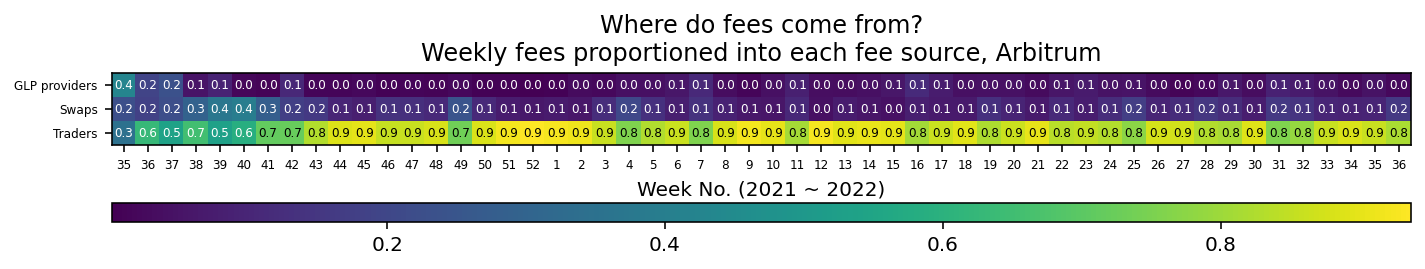

In [12]:
scores_image = heatmap(
    da.T, xlabel='Week No. '+period, 
    ylabel='', xticklabels=da.index.get_level_values(1),
    yticklabels=da.columns.map({'trader_fees_pct':'Traders', 'swap_fees_pct':'Swaps', 'glper_fees_pct':'GLP providers'}),
    cmap=plt.cm.viridis, fmt='%.1f', text_size=6
)
plt.title("Where do fees come from?\nWeekly fees proportioned into each fee source, {}".format(chain)) 
plt.colorbar(scores_image, location="bottom", aspect=70)
plt.tight_layout()
plt.savefig(os.path.join(save_fig_dir, 'fees_sources.png'), dpi=300);

For most of the time, traders contributed 80% - 90% of the fees, swaps 10% - 20%, and GLP providers 10% or less. 

GMX opened shop on Arbitrum in week 35 of 2021, and during that first week, 40% of the fees came from GLP providers. It was caused by large volume of liquidity seeding within the first three days after the platform opened to public. Since then, this figure has dropped, first, to 20%, and then to 10% and below. For most of the history, fees from GLP providers stayed below 10%.

Swap fees hit as high as 40% early on, but came down at 20% in week 42 of 2021. Afterwards, it stayed around 10% most of the time, with occasional visits to 20%. 

Fees from trading related activities has stayed at 70% or above since week 41 of 2021, hitting 80% - 90% most of the time. 

## Prep Swap Sources Data

In [13]:
df_swap_src = pd.read_csv(os.path.join(data_dir, chain, fnames['Swap Sources']), 
                          parse_dates=['Date'], index_col='Date') # , usecols=range(6)
# calc daily total 
df_swap_src['total'] = df_swap_src.sum(axis=1)
# some cols have heavy missings. Don't need to deal them cuz we'll sum and they'll be treated as 0 by default. 

# drop the last row because the most recent date may not be a full day
df_swap_src = df_swap_src.iloc[:-1, :]
print(df_swap_src.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2022-08-19 to 2022-09-06
Data columns (total 32 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   0xe8c97bf6d084880de38aec1a56d97ed9fdfa0c9b  19 non-null     float64
 1   0xdef171fe48cf0115b1d80b88dc8eab59176fee57  18 non-null     float64
 2   Other                                       19 non-null     float64
 3   GMX                                         19 non-null     float64
 4   0xa3847674f48720739330843acb0604a5a8e5caf8  14 non-null     float64
 5   0x9e32336673b73508a9ecc45423a932da13275864  18 non-null     float64
 6   1inch                                       19 non-null     float64
 7   0x00000000000b69ec332f49b7c4d2b101f93c3bed  19 non-null     float64
 8   0x7ffcc217b4d490591009cfc448b6410ffaf4e4fb  13 non-null     float64
 9   0x34a70de0a4eb42b9a95d46108a34adb91758ee97  12 non-null     float64
 

In [14]:
period = str(df_swap_src.index.min().date()) + ' ~ ' + str(df_swap_src.index.max().date())

da = (df_swap_src.sum(axis=0))
swap_src_ranked = da.sort_values(ascending=False).to_frame('Swap Volume ($)')
swap_src_ranked['Percent'] = swap_src_ranked['Swap Volume ($)'] / swap_src_ranked.loc['total', 'Swap Volume ($)']
swap_src_ranked.index.name = period

# format as currency and %
format_dict = {'Swap Volume ($)': '${:,.0f}', 'Percent': '{:.1%}'}
swap_src_ranked_styled = swap_src_ranked.head(11).style.format(format_dict)
swap_src_ranked_styled

,Swap Volume ($),Percent
2022-08-19 ~ 2022-09-06,,
total,"$189,811,758",100.0%
GMX,"$79,670,477",42.0%
0x8960d1b45a2d15d063b84b34dfb2fb2ca7535527,"$48,739,216",25.7%
1inch,"$17,088,643",9.0%
0x9e32336673b73508a9ecc45423a932da13275864,"$16,903,966",8.9%
0x569a11e9c23f6716073aeae549ec69de6356f9b3,"$10,107,008",5.3%
0xdef171fe48cf0115b1d80b88dc8eab59176fee57,"$4,157,973",2.2%
Other,"$2,854,710",1.5%
0x34a70de0a4eb42b9a95d46108a34adb91758ee97,"$2,594,970",1.4%


In [15]:
# save as png
dfi.export(swap_src_ranked_styled, os.path.join(save_fig_dir, 'swap_volume_by_source.png'))

/usr/local/lib/python3.8/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
[0907/110217.581283:INFO:headless_shell.cc(660)] Written to file /var/folders/qq/v47zfw7s1kn38gw67q4v194r0000gn/T/tmp8eu5tt4k/temp.png.
